<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21d_10kGNAD_optuna_trial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Optuna Studies and Trials

Aggregates and displays studies and trials found in a optuna database 

**Overview of all Studies**
* trial states and hyperparam distribution settings
* visualization of best trials

**Study Details**
* parallel plot of hyperparameters
* hyperparameter importance
* evaluation metrics plots
* training progress

In [680]:
!pip install -q --upgrade optuna >/dev/null

In [681]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt

## Connect Google Drive

In [682]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Database Connection

In [683]:
db_path = "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"
db_name = "10kgnad_optuna"
storage = f"sqlite:///{db_path}{db_name}.db"

## Study Information

In [684]:
from optuna.storages import RDBStorage

class StudyInfo:

    def __init__(self, storage: str):
        self.storage = RDBStorage(url=storage)

    def dist2str(dist: optuna.distributions.BaseDistribution) -> str:
        """Create string representation for parameter distributions."""
        if isinstance(dist, optuna.distributions.UniformDistribution):
            return f"{dist.low} -> {dist.high}"
        if isinstance(dist, optuna.distributions.LogUniformDistribution):
            return f"{dist.low} -> {dist.high} (log)"
        if isinstance(dist, optuna.distributions.CategoricalDistribution):
            return f"{list(dist.choices)}"
        else:
            return str(dist)
    
    def study_details(self) ->pd.DataFrame:

        study_info = []
        study_states = []
        study_dist = []

        for s in optuna.get_all_study_summaries(storage):
            name = s.study_name
            info = {"study_name": name,
                    "start": "???" if s.datetime_start is None else s.datetime_start.date(),
                    "directions": len(s.directions)}
            study_info.append(info)

            study = optuna.load_study(name, storage)
            states = pd.Series([t.state for t in study.get_trials()]).value_counts()
            counts = {str(state).split(".")[1]:count for state, count in states.items()}
            study_states.append(counts)

            dist = study.get_trials()[0].distributions
            dist = {k:dist2str(dist[k]) for k in dist.keys()}
            study_dist.append(dist)

        return (pd.concat([pd.DataFrame(study_info),
                           pd.DataFrame(study_states).fillna(0).astype(int),
                           pd.DataFrame(study_dist)
                          ], axis=1).
                fillna("--").
                set_index("study_name"))

In [685]:
info = StudyInfo(storage)
info.study_details()

,start,directions,COMPLETE,RUNNING,FAIL,PRUNED,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay
study_name,,,,,,,,,,
deepset/gelectra-base_loss-f1_bs16_epoch234,2022-01-01,2,141,6,2,0,6e-05 -> 0.0002 (log),"[2, 3]",[16],0.001 -> 0.01 (log)
distilbert-base-german-cased_loss-f1_bs32_epoch23,2022-01-05,2,237,12,15,25,3e-05 -> 0.0001 (log),"[2, 3]",[32],"[0.001, 0.0]"
distilbert-base-german-cased_loss-f1_bs32_epoch1,2022-01-08,2,47,3,3,30,3e-05 -> 0.0001 (log),[1],[32],0.001 -> 0.01 (log)
deepset/gbert-base_loss-f1_bs32_epoch1,2022-01-08,2,63,2,3,27,3e-05 -> 0.0001 (log),[1],[16],0.001 -> 0.01 (log)
deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,2,36,2,1,126,1e-05 -> 0.0001 (log),"[2, 3]",[16],0.001 -> 0.01 (log)
deepset/gbert-base_loss-f1_bs16_epoch23_len128,2022-01-11,2,145,3,0,0,1e-05 -> 0.0001 (log),"[2, 3]",[16],0.001 -> 0.01 (log)
deepset/gelectra-large_loss-f1_bs16_epoch1_len128,2022-01-12,2,41,2,0,0,1e-05 -> 0.0001 (log),[1],[16],0.001 -> 0.01 (log)
distilbert-base-german-cased_loss-f1_bs16_epoch1,2022-01-13,2,190,1,1,0,4e-05 -> 0.0004 (log),[1],[16],0.001 -> 0.01 (log)
distilbert-base-german-cased_loss-f1_bs8-16-32_ep1,2022-01-14,2,191,0,6,0,1e-05 -> 0.0004 (log),[1],"[8, 16, 32]",0.001 -> 0.01 (log)


## Best Results of Studies

In [686]:
stats = []
attrs = []
params = []
for s in optuna.get_all_study_summaries(storage):
    study = optuna.load_study(s.study_name, storage)
    for i, t in enumerate(study.best_trials):
        stats.append({"study_name": s.study_name,
                      "start": t.datetime_start.date(),
                    #   "best_count": i+1,
                      "trial_number": t.number,
                      })
        ua = t.user_attrs
        if "eval_result" in ua.keys():
            ua = ua["eval_result"]
        attrs.append(ua)
        params.append(t.params)

best_trials_df = pd.concat([pd.DataFrame(stats),
                            pd.DataFrame(attrs),
                            pd.DataFrame(params)], axis=1)
best_trials_df.drop(inplace=True, columns = [c for c in best_trials_df.columns if "per_second" in c])
best_trials_df.drop(inplace=True, columns = ["epoch"])
best_trials_df.rename(inplace=True, columns = {"num_train_epochs": "epochs",
                                               "per_device_train_batch_size": "bs"})
best_trials_df.sort_values(["study_name", "eval_loss"])

,study_name,start,trial_number,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,learning_rate,epochs,bs,weight_decay
37,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-10,69,0.301759,0.909533,0.905483,0.907737,0.904167,0.896532,19.7712,0.000015,3,16,0.004746
36,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-10,56,0.301862,0.909533,0.906220,0.909163,0.904167,0.896495,19.7067,0.000015,3,16,0.007156
34,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,5,0.302235,0.911479,0.909600,0.910222,0.909650,0.898701,19.7397,0.000019,3,16,0.001217
38,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-10,72,0.305583,0.911479,0.910440,0.911245,0.910436,0.898718,19.7097,0.000019,3,16,0.001376
33,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,3,0.312597,0.911479,0.911428,0.911844,0.911582,0.898648,19.7429,0.000025,3,16,0.001816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-15,61,0.362643,0.885214,0.883379,0.882434,0.884953,0.868551,6.8065,0.000217,1,32,0.001805
59,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-15,0,0.344781,0.892996,0.891431,0.890736,0.892605,0.877490,7.2683,0.000206,2,32,0.002935
60,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-15,3,0.352662,0.894942,0.892860,0.889610,0.896527,0.879753,7.2550,0.000139,2,32,0.006937
62,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-15,21,0.355923,0.892023,0.893000,0.891272,0.895258,0.876443,7.2756,0.000172,2,32,0.001027


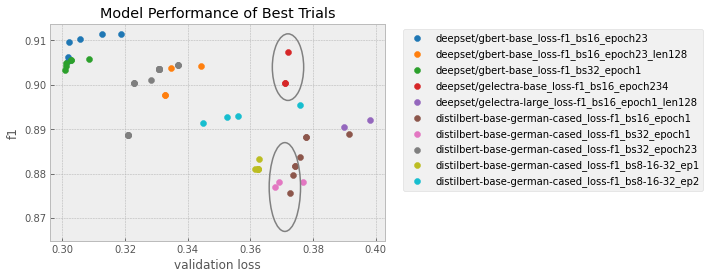

In [687]:
from matplotlib.patches import Ellipse
import seaborn as sns
pal = sns.color_palette("tab10", 10)

plt.style.use('bmh')

for i, s in enumerate(sorted(best_trials_df.study_name.unique())):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.eval_loss, df.eval_f1, label=s, color=pal[i%10])


ax = plt.gca()
ax.add_patch(Ellipse(xy=(0.371, 0.877), width=0.01, height=0.02, edgecolor='gray', fc='None', lw=1.5))
ax.add_patch(Ellipse(xy=(0.372, 0.904), width=0.01, height=0.015, edgecolor='gray', fc='None', lw=1.5))

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("validation loss")
plt.ylabel("f1")
plt.title("Model Performance of Best Trials");

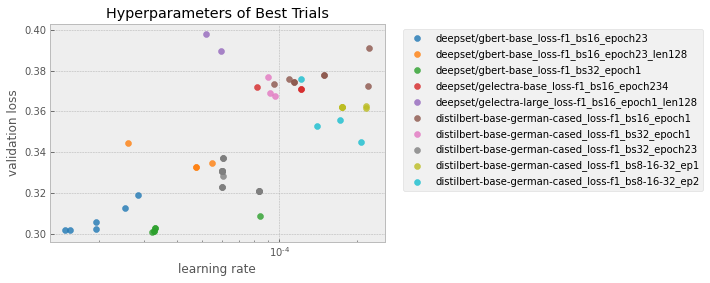

In [688]:
for i, s in enumerate(sorted(best_trials_df.study_name.unique())):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.learning_rate, df.eval_loss, label=s, color=pal[i%10], alpha=0.8)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xscale("log")
plt.xlabel("learning rate")
plt.ylabel("validation loss")
plt.title("Hyperparameters of Best Trials");

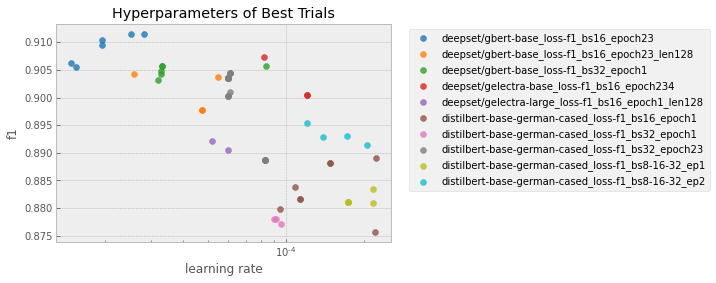

In [689]:
for i, s in enumerate(sorted(best_trials_df.study_name.unique())):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.learning_rate, df.eval_f1, label=s, color=pal[i%10], alpha=0.8)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xscale("log")
plt.xlabel("learning rate")
plt.ylabel("f1")
plt.title("Hyperparameters of Best Trials");

In [690]:
# optuna.delete_study('distilbert-base-german-cased_multi_mcc', storage)
[s.study_name for s in optuna.get_all_study_summaries(storage)]

['deepset/gelectra-base_loss-f1_bs16_epoch234',
 'distilbert-base-german-cased_loss-f1_bs32_epoch23',
 'distilbert-base-german-cased_loss-f1_bs32_epoch1',
 'deepset/gbert-base_loss-f1_bs32_epoch1',
 'deepset/gbert-base_loss-f1_bs16_epoch23',
 'deepset/gbert-base_loss-f1_bs16_epoch23_len128',
 'deepset/gelectra-large_loss-f1_bs16_epoch1_len128',
 'distilbert-base-german-cased_loss-f1_bs16_epoch1',
 'distilbert-base-german-cased_loss-f1_bs8-16-32_ep1',
 'distilbert-base-german-cased_loss-f1_bs8-16-32_ep2']

## Load Study

In [691]:
# study = optuna.load_study('deepset/gbert-base_bs16_epoch234', storage)
# study = optuna.load_study('deepset/gelectra-base_loss-f1_bs16_epoch234', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_epoch1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs16_epoch1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_epoch23', storage)
study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs8-16-32_ep2', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs32_epoch1', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs16_epoch23', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs16_epoch23_len128', storage)
# study = optuna.load_study('deepset/gelectra-large_loss-f1_bs16_epoch1_len128', storage)

## Hyperparameter Overview

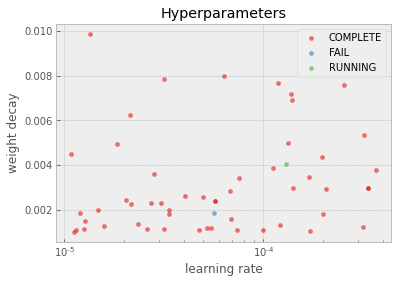

In [692]:
from optuna.trial import TrialState

params = []
for t in study.get_trials(deepcopy=False):
    params.append({"state": str(t.state).split('.')[1], **t.params})
state_params_df = pd.DataFrame(params)

pal = sns.color_palette("Set1")

field="state"
for i, f in enumerate(sorted(state_params_df[field].unique())):
    df = state_params_df[lambda x: x[field] == f]
    plt.scatter(df.learning_rate, df.weight_decay, alpha=0.6, s=16, label=f, color=pal[i])
plt.legend()
plt.xscale("log")
plt.title("Hyperparameters")
plt.xlabel("learning rate")
plt.ylabel("weight decay");

## Analyze Zombie Trials

Interupted trials left in RUNNING state.

In [693]:
from optuna.trial import TrialState

running_trials = study.get_trials(states=[TrialState.RUNNING])

pd.DataFrame([t.params for t in running_trials])

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay
0,0.00013,2,16,0.00405


## Analyze Complete Trials

In [694]:
from optuna.trial import TrialState

complete_trials = study.get_trials(states=[TrialState.COMPLETE])

def get_metrics(trial):
    attrs = trial.user_attrs
    if "eval_result" in attrs.keys():
        attrs = attrs["eval_result"]
    return attrs

# compile trial details for further analysis
if len(complete_trials) > 0:
    index = [t.number for t in complete_trials]
    trial_metrics_df = pd.DataFrame([get_metrics(t) for t in complete_trials], index=index)
    trial_params_df = pd.DataFrame([t.params for t in complete_trials], index=index)
    trial_df = pd.concat([trial_params_df, trial_metrics_df], axis=1).sort_values("eval_loss", ascending=True)
    best = [t.number for t in study.best_trials]
    trial_df["best"] = trial_df.index.isin(best)
    main_metric = "eval_loss"
    trial_params_df[main_metric] = trial_metrics_df[main_metric]
    display(trial_df.head(10))
else:
    raise ValueError("there must be at least one complete trial")

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,best
0,0.000206,2,32,0.002935,0.344781,0.892996,0.891431,0.890736,0.892605,0.877490,7.2683,141.435,4.540,2.0,True
3,0.000139,2,32,0.006937,0.352662,0.894942,0.892860,0.889610,0.896527,0.879753,7.2550,141.695,4.549,2.0,True
21,0.000172,2,32,0.001027,0.355923,0.892023,0.893000,0.891272,0.895258,0.876443,7.2756,141.294,4.536,2.0,True
22,0.000200,2,32,0.001818,0.364962,0.893969,0.892000,0.891834,0.893483,0.878659,7.2860,141.093,4.529,2.0,False
53,0.000034,2,32,0.001992,0.371048,0.881323,0.878747,0.879879,0.878437,0.864028,7.2690,141.422,4.540,2.0,False
47,0.000034,2,32,0.001825,0.371092,0.882296,0.879576,0.880858,0.879099,0.865132,7.2605,141.587,4.545,2.0,False
48,0.000052,2,16,0.001179,0.373212,0.892996,0.892674,0.890367,0.895518,0.877514,7.3009,140.804,8.903,2.0,False
52,0.000336,2,32,0.002987,0.373773,0.890078,0.891184,0.892715,0.890594,0.874195,7.2579,141.640,4.547,2.0,False
19,0.000336,2,32,0.002987,0.373773,0.890078,0.891184,0.892715,0.890594,0.874195,7.2434,141.922,4.556,2.0,False
30,0.000032,2,32,0.001119,0.374927,0.880350,0.877400,0.879092,0.876488,0.862898,7.2984,140.854,4.522,2.0,False


In [695]:
import plotly.express as px

fig = px.parallel_coordinates(trial_df[trial_params_df.columns], color=main_metric, 
                             color_continuous_scale=px.colors.sequential.Oryel)
fig.update_layout(autosize=False, width=700, height=350)
fig.show()

In [696]:
# fig = optuna.visualization.plot_parallel_coordinate(study, target=lambda trial: trial.user_attrs["eval_loss"], target_name="loss")
# fig.update_layout(autosize=False, width=700, height=350)
# fig.show()

In [697]:
# optuna.visualization.plot_contour(study)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



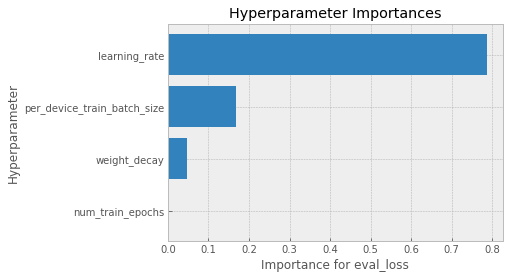

In [698]:
# from optuna.visualization import plot_param_importances
from optuna.visualization.matplotlib import plot_param_importances

fig = plot_param_importances(
    study, target=lambda t: t.values[0], target_name="eval_loss"
)
# fig.update_layout(autosize=False, width=800, height=350)
# fig.show()

In [699]:
def get_loss(trial):
    """Handle different data format versions"""
    if "eval_result" in trial.user_attrs.keys():
        return trial.user_attrs["eval_result"]["eval_loss"]
    else:
        return trial.user_attrs["eval_loss"]

In [700]:
fig = optuna.visualization.plot_slice(study, target=get_loss, target_name="loss")
fig.update_layout(autosize=False, width=900, height=350)
fig.show()

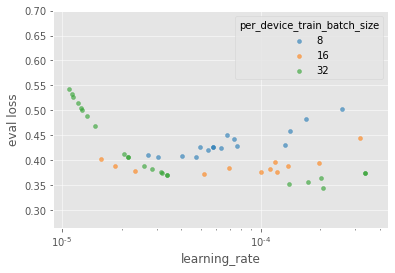

In [701]:
import seaborn as sns

pal = sns.color_palette("tab10", 10)

# plt.scatter(trial_df.eval_loss, trial_df.learning_rate, c=trial_df.best, cmap="Set1_r", alpha=0.6, s=8);
# field = "num_train_epochs"
field = "per_device_train_batch_size"
for i, f in enumerate(sorted(trial_df[field].unique())):
    df = trial_df[lambda x: x[field] == f]
    plt.scatter(df.learning_rate, df.eval_loss, alpha=0.6, s=16, label=f, color=pal[i])

# plt.gca().set_xscale('log')
plt.legend(title=field)
plt.ylim([None, 0.7])
plt.xscale("log")
plt.ylabel("eval loss")
plt.xlabel("learning_rate");

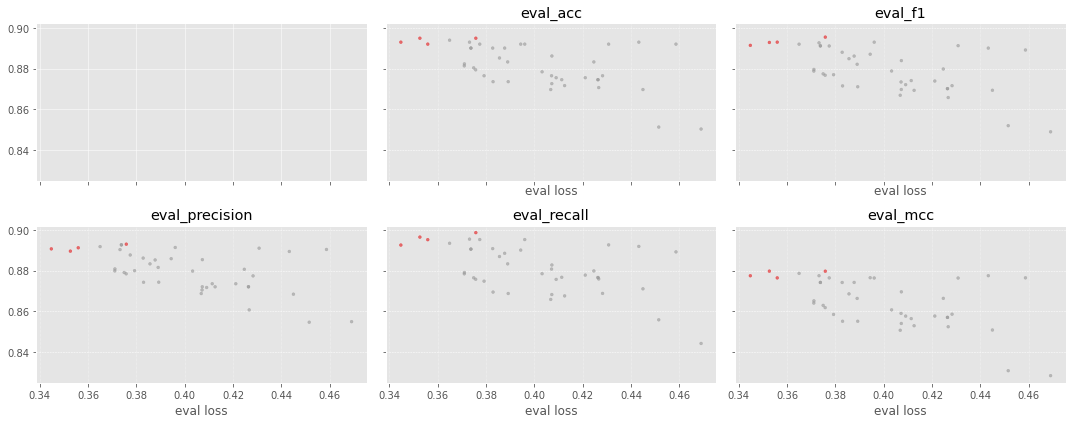

In [702]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

exclude = ["eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]
metrics = [m for m in trial_metrics_df.columns if m not in exclude]

# only focus on low loss trials
loss_df = trial_df[lambda x: x.eval_loss < x.eval_loss.mean()]

for col, ax in zip(metrics, axs.flatten()):
    if col == "eval_loss":
        continue
    ax.scatter(loss_df.eval_loss, loss_df[col], c=loss_df.best, cmap="Set1_r", alpha=0.6, s=8);
    ax.set_title(col)
    ax.set_xlabel("eval loss")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

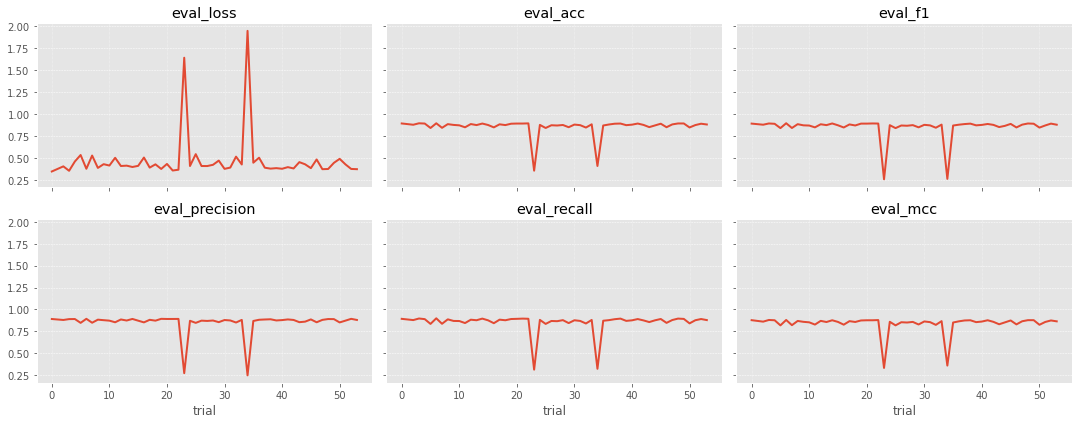

In [703]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

for col, ax in zip(metrics, axs.flatten()):
    trial_df[col].sort_index().plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel("trial")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

## Single Trial - Extract data logged during train

In [704]:
running_trials = [t for t in study.get_trials() if t.state==TrialState.RUNNING]
data = complete_trials[-1].user_attrs
if "eval_result" in data.keys():
    log_df = pd.DataFrame(data.values(), index=data.keys())[lambda x: x.index != "eval_result"]
    log_df.index = log_df.index.astype(int)
    log_df.sort_index(inplace=True)
    display(log_df)

,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,lr
57,0.856826,0.790856,0.774230,0.835616,0.749999,0.760807,7.3310,140.227,4.501,0.20,3.044913e-05
114,0.597858,0.828794,0.822912,0.845480,0.811767,0.804078,7.3333,140.182,4.500,0.39,2.723473e-05
171,0.509920,0.843385,0.839913,0.848734,0.841814,0.822363,7.2975,140.870,4.522,0.59,2.390345e-05
228,0.456393,0.856031,0.854594,0.861941,0.854534,0.835529,7.3096,140.637,4.515,0.79,2.057216e-05
285,0.428853,0.862840,0.865798,0.862796,0.871819,0.843414,7.3134,140.564,4.512,0.99,1.724087e-05
342,0.413390,0.868677,0.868470,0.877193,0.862588,0.849686,7.3196,140.445,4.508,1.18,1.390958e-05
399,0.401583,0.864786,0.862953,0.867315,0.861320,0.845302,7.3393,140.067,4.496,1.38,1.057830e-05
456,0.376990,0.877432,0.874833,0.877667,0.873206,0.859561,7.2932,140.952,4.525,1.58,7.247010e-06
513,0.397914,0.871595,0.869567,0.871408,0.872312,0.853662,7.3483,139.897,4.491,1.78,3.915723e-06
570,0.371048,0.881323,0.878747,0.879879,0.878437,0.864028,7.3196,140.446,4.508,1.97,5.844363e-07


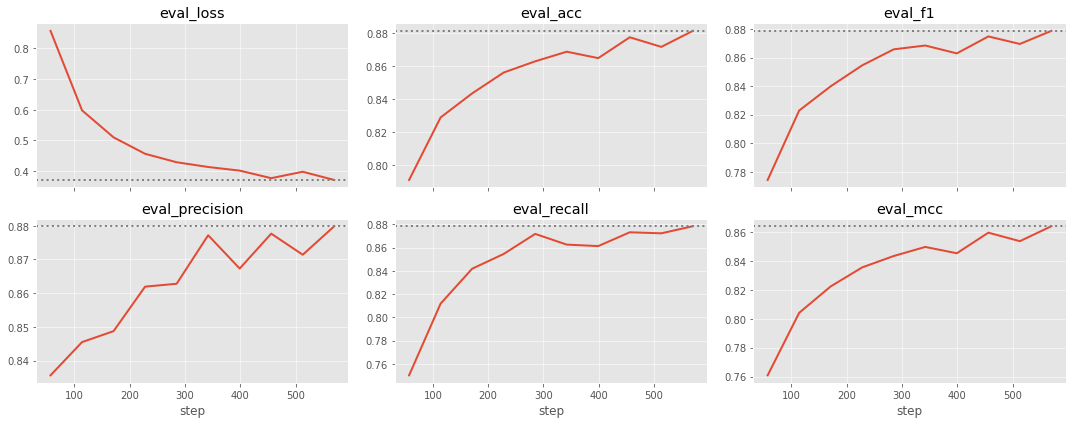

In [705]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True)

for col, ax in zip(metrics, axs.flatten()):
    log_df[col][0:-1].plot(ax=ax).axhline(log_df[col].values[-1], c="grey", linestyle=":")
    ax.set_title(col)
    ax.set_xlabel("step")
    # ax.grid(axis='y', linestyle='--', zorder=1)
    # ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

## Plot Learning Rate

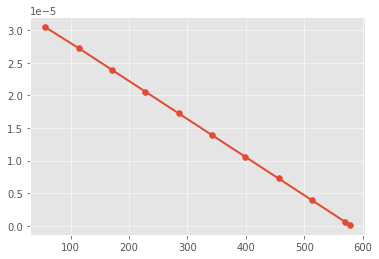

In [706]:
log_df["lr"].plot()
plt.scatter(log_df["lr"].index, log_df["lr"]);

# Plot all Loss Curves

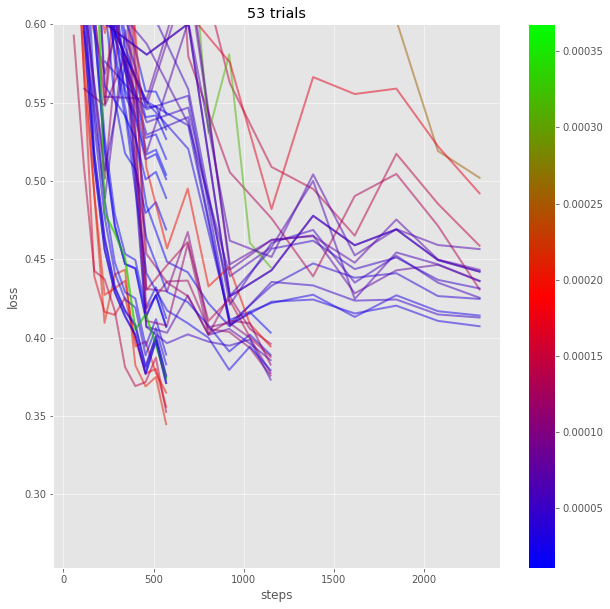

In [707]:
# https://stackoverflow.com/questions/52758070/color-map-to-shades-of-blue-python
# https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,10))

lrs = [t.params["learning_rate"] for t in complete_trials]

# n = len(complete_trials)
n = 101
c = np.linspace(min(lrs),max(lrs),n)
# colors = plt.cm.cool(c)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.brg) # cool

count = 0
for i, t in enumerate(complete_trials):
    if not "eval_result" in t.user_attrs.keys():
        continue
    count += 1
    data = t.user_attrs
    loss_df = pd.DataFrame(data.values(), index=data.keys())[lambda x: x.index != "eval_result"]
    loss_df.index = loss_df.index.astype(int)
    loss_df.sort_index(inplace=True)
    # print(np.log(t.params["learning_rate"]))
    # ax.plot(loss_df["eval_loss"][0:-1], c=colors[i], alpha=0.5)
    # ax.plot(loss_df["eval_loss"][0:-1], c=colors[int(100 * (t.params["learning_rate"] - min(lrs)) / (max(lrs) - min(lrs)))], alpha=0.5)
    ax.plot(loss_df["eval_loss"][0:-1], c=cmap.to_rgba(t.params["learning_rate"]), alpha=0.5)
    # loss_df["eval_loss"].plot(ax=ax, cmap="Blues")
    # print(t.number, loss_df["eval_loss"])
plt.xlabel("steps")
plt.ylabel("loss")
plt.colorbar(cmap)
plt.ylim([None,0.6])
plt.title(f"{count} trials");